In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/affectnet/labels.csv")
df = df.drop(columns="Unnamed: 0")#, inplace=True)
df.head()

,pth,label,relFCs
0,anger/image0000006.jpg,surprise,0.873142
1,anger/image0000060.jpg,anger,0.852311
2,anger/image0000061.jpg,anger,0.800957
3,anger/image0000066.jpg,disgust,0.843079
4,anger/image0000106.jpg,anger,0.849108


In [4]:
df.label.value_counts()

surprise    4616
happy       4336
anger       3608
disgust     3472
contempt    3244
fear        3043
sad         2995
neutral     2861
Name: label, dtype: int64

In [5]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28175 entries, 0 to 28174
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pth     28175 non-null  object 
 1   label   28175 non-null  object 
 2   relFCs  28175 non-null  float64
dtypes: float64(1), object(2)
memory usage: 660.5+ KB


In [6]:
import os
import cv2
path = ('/content/drive/MyDrive/affectnet/')
file = (path + 'labels.csv')

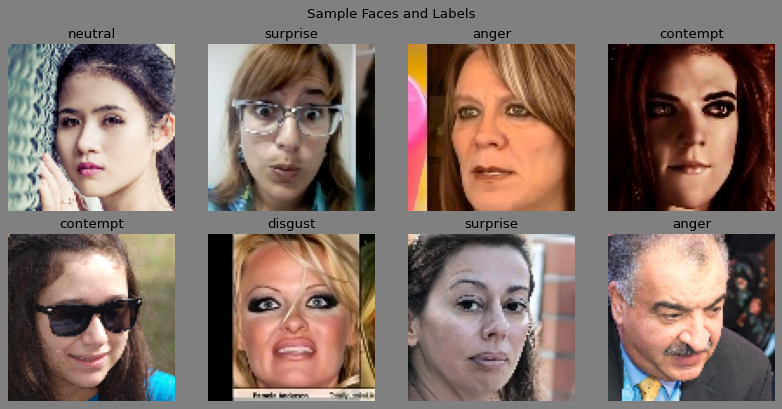

In [7]:
# display random images

import random
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical

fig, axs = plt.subplots(2, 4, sharey=True, constrained_layout=True, num=None, 
                        figsize=(10, 5), dpi=80, facecolor='gray', edgecolor='k')
fig.suptitle("Sample Faces and Labels")
axs = axs.flatten()


for i in range(8):
    idx = random.randint(0, len(df)-1)  # randomly select an index
    img_path = path + df['pth'][idx]
    img = cv2.imread(img_path)  # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to BGR to RGB
    axs[i].imshow(img)
    axs[i].set_title(df['label'][idx])
    axs[i].axis('off')

In [8]:
INPUT_PATH = "/content/drive/MyDrive/affectnet/"
EMOTIONS = [f.name for f in os.scandir(INPUT_PATH) if f.is_dir()]
IMAGE_SIZE = (96,96)

print(EMOTIONS)

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, image_size)
            img = img.astype('float32') / 255.0  # Normilize
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = to_categorical(np.array(y))
    return X, y

['anger', 'fear', 'contempt', 'surprise', 'sad', 'neutral', 'disgust', 'happy']


In [9]:
# Load the images 1
X, y = load_images(INPUT_PATH, EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape
#input_shape = (96,96,1) 

In [10]:
input_shape

(96, 96, 3)

In [11]:
y[:10]

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

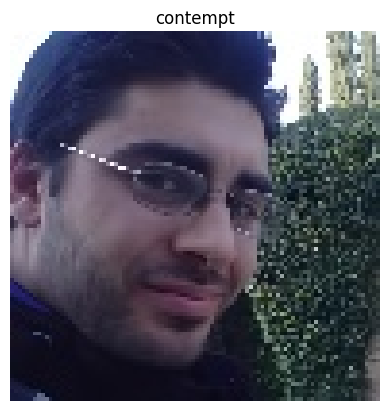

In [12]:
# choose a random image index
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx])
plt.title(EMOTIONS[np.argmax(y[idx])])
plt.axis('off')  # remove the grid
plt.show()

In [13]:
# Train test split pre-processed data

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)#, stratify = y)

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import layers
model_2 = Sequential()

model_2.add(Conv2D(32, (3,3), activation="relu", input_shape=input_shape))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.20))

model_2.add(Conv2D(64, (3,3), activation="relu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.15))
model_2.add(Conv2D(128, (3,3), activation="relu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.15))

model_2.add(Flatten())
model_2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model_2.add(BatchNormalization())
#model_2.add(Dropout(0.2))
model_2.add(Dense(8, activation='softmax'))

model_2.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 45, 45, 64)       2

In [15]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(horizontal_flip = True, 
                               rotation_range = 0.10, 
                               width_shift_range = 0.10,
                               height_shift_range = 0.10, 
                               zoom_range = 0.15)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history_2 = model_2.fit(gen.flow(X_train, y_train, batch_size=64),
                    epochs=50,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [#EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                # save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/50
363/363 [==============================] - 82s 188ms/step - loss: 3.8102 - accuracy: 0.2933 - val_loss: 2.7220 - val_accuracy: 0.2390 - lr: 0.0010
Epoch 2/50
363/363 [==============================] - 61s 169ms/step - loss: 2.2580 - accuracy: 0.4065 - val_loss: 2.4626 - val_accuracy: 0.3146 - lr: 0.0010
Epoch 3/50
363/363 [==============================] - 61s 167ms/step - loss: 1.9540 - accuracy: 0.4605 - val_loss: 5.0208 - val_accuracy: 0.1634 - lr: 0.0010
Epoch 4/50
363/363 [==============================] - 65s 179ms/step - loss: 1.8179 - accuracy: 0.4959 - val_loss: 1.8251 - val_accuracy: 0.4777 - lr: 0.0010
Epoch 5/50
363/363 [==============================] - 60s 166ms/step - loss: 1.7258 - accuracy: 0.5199 - val_loss: 4.5434 - val_accuracy: 0.2616 - lr: 0.0010
Epoch 6/50
363/363 [==============================] - ETA: 0s - loss: 1.6807 - accuracy: 0.5346
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
363/363 [============================

182/182 [==============================] - 1s 5ms/step


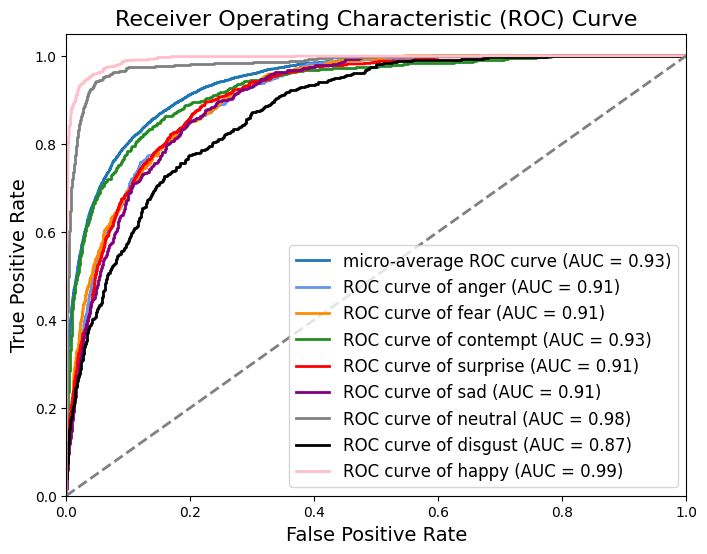

In [ ]:
# calculates the false positive rate, true positive rate, and AUC score

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions
y_pred = model_2.predict(X_test)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')

# Plot the ROC curves for each class and the micro-average ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr["micro"], tpr["micro"], lw=lw, label='micro-average ROC curve (AUC = {0:0.2f})'
                                                   ''.format(roc_auc["micro"]))
colors = ['cornflowerblue', 'darkorange', 'forestgreen', 'red', 'purple', 'gray', 'black', 'pink']
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (AUC = {1:0.2f})'.format(EMOTIONS[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [ ]:
from keras.models import load_model
model_2.load_weights('best_model.h5')
model_2.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Compute classification report

from sklearn.metrics import classification_report, confusion_matrix

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model_2.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))



182/182 [==============================] - 25s 48ms/step
              precision    recall  f1-score   support

           0       0.51      0.58      0.55       647
           1       0.64      0.43      0.51       650
           2       0.63      0.63      0.63       566
           3       0.50      0.70      0.58       802
           4       0.50      0.53      0.51       596
           5       0.86      0.89      0.87      1012
           6       0.54      0.29      0.38       504
           7       0.92      0.90      0.91      1030

    accuracy                           0.67      5807
   macro avg       0.64      0.62      0.62      5807
weighted avg       0.67      0.67      0.66      5807



In [ ]:
cm = confusion_matrix(y_test_int, y_pred_int)
DetaFrame_cm = pd.DataFrame(cm)
DetaFrame_cm

,0,1,2,3,4,5,6,7
0,375,16,46,67,84,3,56,0
1,44,277,13,217,80,1,18,0
2,57,10,359,66,47,11,8,8
3,36,78,39,563,31,37,12,6
4,73,28,63,84,315,3,30,0
5,8,0,4,39,7,897,2,55
6,136,23,43,78,66,4,146,8
7,0,1,2,11,0,85,0,931


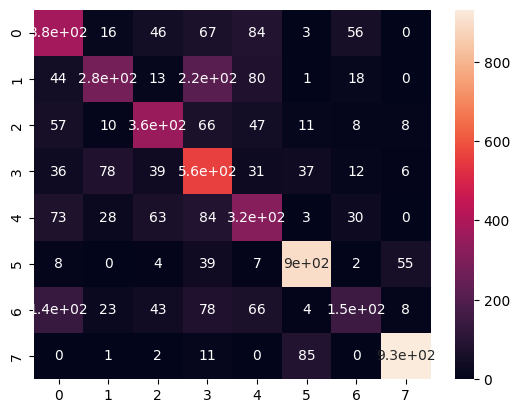

In [ ]:
import seaborn as sns

sns.heatmap(DetaFrame_cm, annot=True)
plt.show()

In [16]:
import tensorflow as tf
from keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet152V2,VGG16, efficientnet_v2

from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow.keras import layers
from tensorflow import keras

In [17]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential, Model

In [18]:
def extractor_model():

    vgg_16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg_16.trainable = False
    x = vgg_16.output
    x = layers.Flatten(name="flatten")(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(8, activation="softmax")(x)

    model = Model(inputs=vgg_16.input, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, 
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
    
    return model

In [19]:
model_3 = extractor_model()
model_3.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history_3 = model_3.fit(gen.flow(X_train, y_train, batch_size=64),
                    epochs=50,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [#EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model_vgg.h5', 
                                                 save_best_only=True, 
                                                 #save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/50
363/363 [==============================] - 111s 275ms/step - loss: 1.7257 - accuracy: 0.3532 - val_loss: 1.5664 - val_accuracy: 0.4069 - lr: 0.0010
Epoch 2/50
363/363 [==============================] - 102s 280ms/step - loss: 1.5491 - accuracy: 0.4133 - val_loss: 1.4991 - val_accuracy: 0.4336 - lr: 0.0010
Epoch 3/50
363/363 [==============================] - 1799s 5s/step - loss: 1.4982 - accuracy: 0.4383 - val_loss: 1.4791 - val_accuracy: 0.4467 - lr: 0.0010
Epoch 4/50
363/363 [==============================] - 210s 577ms/step - loss: 1.4666 - accuracy: 0.4477 - val_loss: 1.4553 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 5/50
363/363 [==============================] - 71s 196ms/step - loss: 1.4430 - accuracy: 0.4587 - val_loss: 1.4585 - val_accuracy: 0.4526 - lr: 0.0010
Epoch 6/50
363/363 [==============================] - 74s 203ms/step - loss: 1.4173 - accuracy: 0.4716 - val_loss: 1.4315 - val_accuracy: 0.4646 - lr: 0.0010
Epoch 7/50
363/363 [==============================

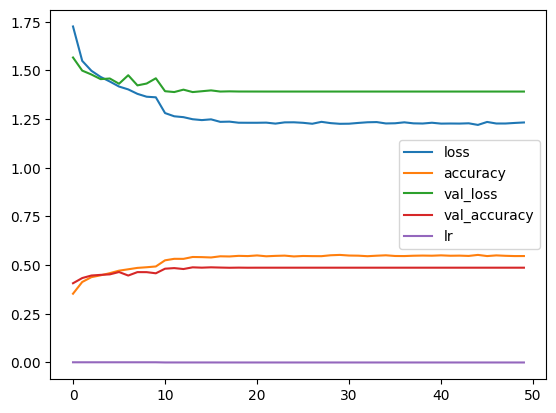

In [22]:
pd.DataFrame(history_3.history).plot();